In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

In [3]:
class Processing:
    
    def __init__(self, image_path, mask=None, df=None):
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError("Image could not be read. Check the path.")
        if mask is not None:
            self.mask = mask
        else:
            self.mask = np.zeros(self.image.shape[:2], np.uint8)
        self.df = df

In [5]:
class Texture(Processing):
    
    def histogramming(self):
        histSize = 256
        histRange = (0, 256)
        accumulate = False
        b = self.image[:,:,0]
        b_hist = cv2.calcHist([b], [0], None, [histSize], histRange, accumulate=accumulate)
        plt.plot(b_hist)
        plt.title("Гистограмма яркости (B)")
        plt.xlabel("Яркость")
        plt.ylabel("Частота")
        plt.show()
        b_hist_cum = b_hist.cumsum()
        plt.plot(b_hist_cum)
        plt.title("Кумулятивная гистограмма яркости (B)")
        plt.xlabel("Яркость")
        plt.ylabel("Кумулятивная частота")
        plt.show()

    def textural(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        mean = np.mean(gray_image)
        variance = np.var(gray_image)
        std_dev = np.std(gray_image)
        return mean, variance, std_dev

    def lavs_characteristics(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
        mean = np.mean(laplacian)
        variance = np.var(laplacian)
        std_dev = np.std(laplacian)
        return mean, variance, std_dev

    def calculate_entropy(self, glcm):
        glcm_normalized = glcm / np.sum(glcm)
        glcm_nonzero = glcm_normalized[glcm_normalized > 0]
        return -np.sum(glcm_nonzero * np.log2(glcm_nonzero))

    def glcm_analysis(self, distances=[1], angles=[0]):
        gray_image = rgb2gray(self.image)
        gray_image = img_as_ubyte(gray_image)
        
        glcm = graycomatrix(gray_image, distances=distances, angles=angles, levels=256, symmetric=True, normed=False)
        
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        entropy = self.calculate_entropy(glcm[:, :, 0, 0])
        
        features = {
            'contrast': contrast,
            'energy': energy,
            'homogeneity': homogeneity,
            'entropy': entropy
        }
        
        return glcm[:, :, 0, 0], features
    
    def visualize_glcm(self, glcm):
        plt.figure(figsize=(8, 6))
        plt.imshow(glcm, cmap='gray', interpolation='nearest')
        plt.title("Матрица взаимной встречаемости пикселей")
        plt.xlabel("Уровень 1")
        plt.ylabel("Уровень 2")
        plt.colorbar(label="Частота")
        plt.show()

In [25]:
class Seg(Processing):

    def homo_average(self, img, mask, i, j, T):
        point = (i,j)
        av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                                
        if abs(av_val - img[point]) <= T:
            return True
        
        return False

    def region_growing(self, seed_point, r, T):
        image_gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        mask = np.zeros(image_gray.shape, np.uint8)
        mask[seed_point] = 1
        count = 1
        while count > 0:
            count = 0
            local_mask = np.zeros(image_gray.shape, np.uint8)
            for i in range(r, self.image.shape[0] - r):
                for j in range(r, self.image.shape[1] - r):
                    if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                        if self.homo_average(self.image, mask, i, j, T):
                            local_mask[i,j] = 1
            count = np.count_nonzero(local_mask)
            print(count)
            mask += local_mask
            
        return mask*255

    def kmeans(self):
        image_gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        flags = cv2.KMEANS_RANDOM_CENTERS
        z = image_gray.reshape((-1,3))
        z = np.float32(z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 3
        ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        res2 = res.reshape((image_gray.shape))
        return res2
    
    def watershed_segmentation(self):
        image_gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
        ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
        sure_fg = sure_fg.astype(np.uint8)
        ret, markers = cv2.connectedComponents(sure_fg) 
        markers = cv2.watershed(self.image, markers)
        return markers

    def homo_average(img, mask, point, T):
        av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                                
        if abs(av_val - img[point]) <= T:
            return True
        
        return False

    def region_growing(image, seed_point, homo_fun, r, T):
        mask = np.zeros(image_gray.shape, np.uint8)
        mask[seed_point] = 1
        count = 1
        while count > 0:
            count = 0
            local_mask = np.zeros(image_gray.shape, np.uint8)
            for i in range(r, image.shape[0] - r):
                for j in range(r, image.shape[1] - r):
                    if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                        if homo_fun(image, mask, (i,j), T):
                            local_mask[i,j] = 1
            count = np.count_nonzero(local_mask)
            print(count)
            mask += local_mask
            
        return mask*255

Mean: 141.29314924911253, Variance: 402.1851190896663, Std Dev: 20.05455357492822
Laplacian Mean: 3.719474274628127e-06, Variance: 3.3533366659684494, Std Dev: 1.8312118025964252


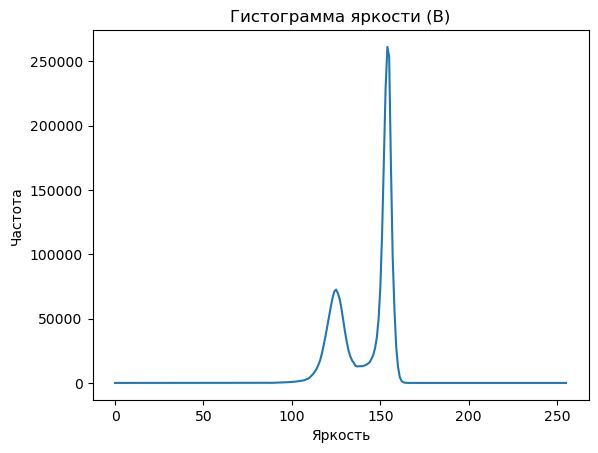

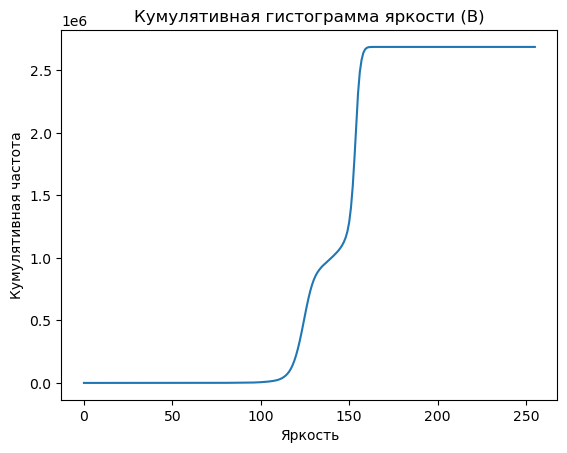

Характеристи матрицы взаимной встречаемости пикселя
{'contrast': 1.3988710795636599, 'energy': 0.13061338758616578, 'homogeneity': 0.7001257779597899, 'entropy': 7.221338473064576}

Матрица взаимной встречаемости пикселя
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


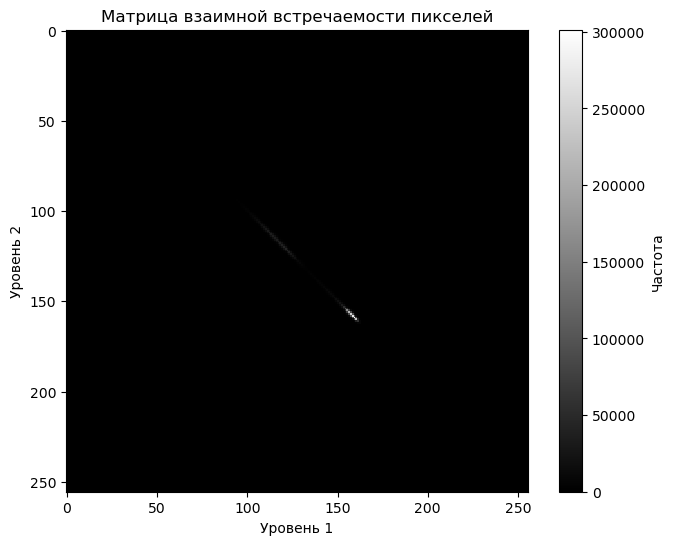

In [12]:
image_path = '11.jpg'  # Укажите путь к изображению
im = Texture(image_path)

# Выполните текстурный анализ
mean, variance, std_dev = im.textural() # ***
print(f"Mean: {mean}, Variance: {variance}, Std Dev: {std_dev}") # ***

lap_mean, lap_variance, lap_std_dev = im.lavs_characteristics() # ***
print(f"Laplacian Mean: {lap_mean}, Variance: {lap_variance}, Std Dev: {lap_std_dev}")# ***

im.histogramming()# ***

glcm, features = im.glcm_analysis()
print("Характеристи матрицы взаимной встречаемости пикселя")# ***
print(features)# ***
print("\nМатрица взаимной встречаемости пикселя")# ***
print(glcm)# ***
im.visualize_glcm(glcm)# ***

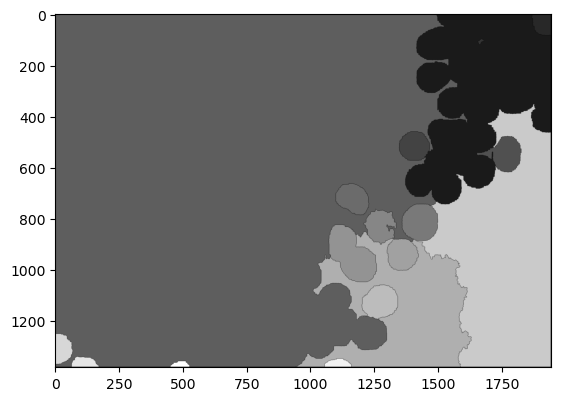

In [13]:
image_path = '11.jpg'  # Укажите путь к изображению
im = Seg(image_path)

# Выполните сегментацию
image = im.watershed_segmentation() # ***
plt.imshow(image, cmap="gray")

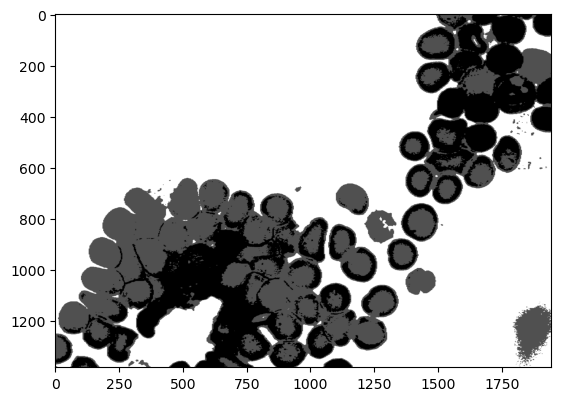

In [15]:
image = im.kmeans() # ***
plt.imshow(image, cmap="gray")

In [30]:
image_path = 'sick.jpg'  # Укажите путь к изображению
image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
# Выбираем точку начала роста региона (seed)
seed_point = (200, 200)  # Измените координаты в зависимости от вашего изображения

# Запускаем алгоритм роста региона
r = 3  # Радиус соседства
T = 10  # Порог гомогенности
mask = Seg.region_growing(image_gray, seed_point, Seg.homo_average, r, T) # ***

25
56
76
56
56
62
70
73
78
82
90
98
104
112
120
131
139
148
158
168
129
34
34
31
27
26
24
20
20
20
19
17
15
14
14
14
13
12
10
8
8
10
11
8
8
8
8
8
8
8
9
10
10
10
12
12
12
12
12
13
14


KeyboardInterrupt: 